Learn the inter-grid prolongation operator (P) for two-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions (from FEniCS)
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        # self.plate.set_square_bc(bc) set the boundary values
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [15]:
n = 2**4
grid = SingleGrid(size=2,n=n)

In [16]:
EPS = 5e-5
n_jac = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f = grid.fnet(torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)) # assign the finest rhs 
residual = f-grid.Knet(u)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u = grid.Relax(u, f, 1)
    residual = f-grid.Knet(u)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")

0 0.220755934715271
1 0.2116060107946396
2 0.2042391300201416
3 0.19790019094944
4 0.19225135445594788
5 0.18710699677467346
6 0.18235228955745697
7 0.17791017889976501
8 0.1737261712551117
9 0.16975991427898407
10 0.16598062217235565
11 0.162364199757576
12 0.15889130532741547
13 0.1555461883544922
14 0.15231604874134064
15 0.1491900533437729
16 0.14615918695926666
17 0.14321574568748474
18 0.1403532773256302
19 0.13756616413593292
20 0.13484960794448853
21 0.1321994811296463
22 0.12961210310459137
23 0.1270843893289566
24 0.12461347877979279
25 0.12219694256782532
26 0.11983257532119751
27 0.11751840263605118
28 0.11525262892246246
29 0.11303374916315079
30 0.1108601912856102
31 0.10873057693243027
32 0.10664381086826324
33 0.10459860414266586
34 0.10259389877319336
35 0.10062874853610992
36 0.09870215505361557
37 0.09681320935487747
38 0.09496109187602997
39 0.09314487874507904
40 0.09136389940977097
41 0.08961738646030426
42 0.08790453523397446
43 0.08622467517852783
44 0.084577172

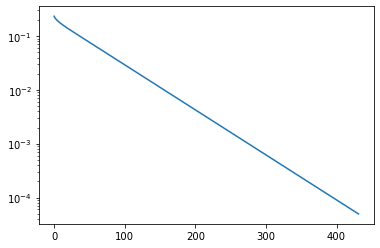

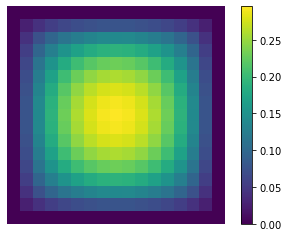

In [17]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [18]:
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_17x17.h5')
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

In [19]:
u, f, bc_value, bc_index = next(iter(train_dataloader))

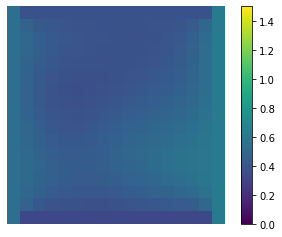

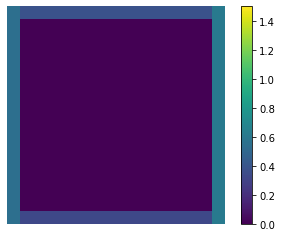

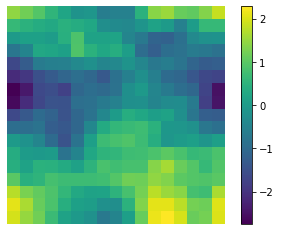

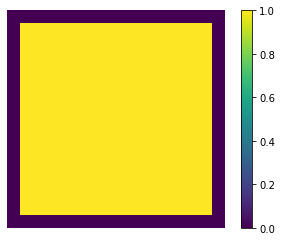

In [21]:
k=22
plot.plot_field(u[k,0],limit=[0,1.5])
plot.plot_field(bc_value[k,0],limit=[0,1.5])
plot.plot_field(f[k,0])
plot.plot_field(bc_index[k,0])

In [ ]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0

In [ ]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 16
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        '''The input should have already been splitted'''
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 16
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        '''The input should have already been splitted'''
        return self.net(x_split)


class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, x):
        "Compute the loss after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        return torch.mean(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3)))

    def random_sampling(self, v):
        d1, d2, d3, d4 = v.shape
        for i in range(d1):
            for j in range(d2):
                coef = 10*np.random.rand(2) - 5
                v[i, j, :, :] = torch.from_numpy(coef[0]*np.random.random((d3,d4)) + coef[1])

    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        self.random_sampling(self.v)
        U = torch.clone(self.v)
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [ ]:
n = 2**4
model = MultiGrid(n, linear_tensor_P)
rhs = next(iter(train_dataloader))

0 0.1232331320643425
1 0.09740164130926132
2 0.07685525715351105
3 0.06036091223359108
4 0.04727867245674133
5 0.03697541356086731
6 0.02889365702867508
7 0.02256830409169197
8 0.017623329535126686
9 0.013760613277554512
10 0.010743888095021248
11 0.008388717658817768
12 0.006549330893903971
13 0.0051130871288478374
14 0.003992211073637009
15 0.0031168165151029825
16 0.002433421090245247
17 0.0018996394937857985
18 0.0014830140862613916
19 0.0011579927522689104
20 0.0009040304576046765
21 0.0007058448973111808
22 0.0005511160707101226
23 0.00043027944047935307
24 0.00033576347050257027
25 0.00026192585937678814
26 0.00020481877436395735
27 0.00015968010120559484
28 0.00012476911069825292
29 9.762954869074747e-05
30 7.601979450555518e-05
31 5.927325037191622e-05
32 4.634820652427152e-05
Solution converges after 33 multi-grid iterations 


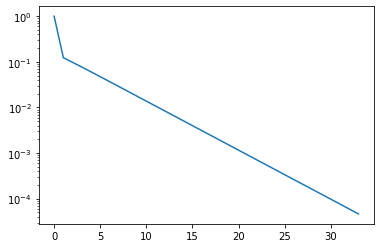

In [ ]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [ ]:
model_dir = 'Model/multigrid_rhs_res'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


In [ ]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list'''
    for i in list:
        para_list[0].grad[:,i] = torch.zeros_like(para_list[0].grad[:,i])

def rewrite_kernels(para_list, list, P_kernel):
    '''Overwrite the kernels in list to be 'P_kernel' '''
    for i in list:
        para_list[0][:,i].data = P_kernel

def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    for i in range(16):
        para_list[1][i,:] = para_list[0][:,i].detach()


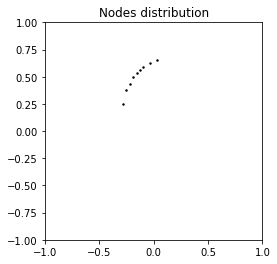

In [ ]:
kernel_i = 12
mesh = MeshCenterInterface(nnode_edge = n+1, outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

In [ ]:
model_name = 'model_mg_interface_kernel'+str(kernel_i)

freeze_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # freeze a kernel
freeze_list.remove(kernel_i)

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_i = model.loss(u_out)
        
        loss_i.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, linear_tensor_P)
        # update the P kernels
        copy_kernels(para_list)
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [ ]:
num_epoch = 500
best_vloss = 1_000_000.

loss_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_loss = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train.append(avg_loss)


0 17.759594917297363
1 18.149947822093964
2 18.160227417945862
3 18.293397963047028
4 18.019722163677216
5 18.26423990726471
6 17.768357574939728
7 18.08305597305298
8 17.687570571899414
9 18.461331009864807
10 18.183533370494843
11 18.252383589744568
12 17.838234663009644
13 17.589123129844666
14 18.21046483516693
15 17.674479961395264
16 18.47877609729767
17 17.95086419582367
18 18.015572786331177
19 18.11363935470581
20 17.984111785888672
21 17.905856728553772
22 17.790697693824768
23 17.99763596057892
24 18.22875726222992
25 18.057834267616272
26 18.37077295780182
27 17.802729845046997
28 17.935868978500366
29 18.23327147960663
30 18.337452173233032
31 18.500542402267456
32 17.91778802871704
33 18.439167261123657
34 17.955554842948914
35 18.094971776008606
36 18.060826063156128
37 18.429611921310425
38 18.406538128852844
39 18.733012437820435
40 17.905943274497986
41 18.572347402572632
42 18.181657135486603
43 18.30053073167801
44 17.94018644094467
45 17.81855934858322
46 17.703376

Text(0.5, 0, 'epoch')

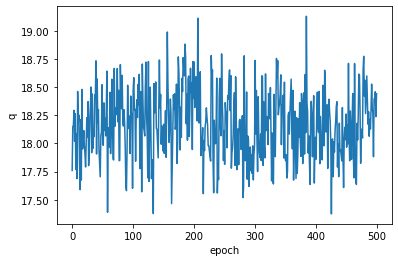

In [ ]:
plt.plot(loss_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [ ]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),loss_train)

In [ ]:
print('Learned parameters:')
print('Restriction kernel:', mlist[0][0][kernel_i])
print('Interpolation kernel:', mlist[1][kernel_i][0])

print()

print('Previous parameters:')
print('Restriction kernel:', mlist[0][0][kernel_i+1])
print('Interpolation kernel:', mlist[1][kernel_i+1][0])


Learned parameters:
Restriction kernel: tensor([[ 0.1939,  0.4989,  0.3448],
        [ 0.3967,  0.7553,  0.7315],
        [-0.0049,  0.4940,  0.4847]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[ 0.1939,  0.4989,  0.3448],
        [ 0.3967,  0.7553,  0.7315],
        [-0.0049,  0.4940,  0.4847]])

Previous parameters:
Restriction kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])


In [ ]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [ ]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 1.6177523136138916
1 0.3134882152080536
2 0.35464394092559814
3 0.3025338053703308
4 0.3007097542285919
5 0.2907876670360565
6 0.28362077474594116
7 0.27616918087005615
8 0.2690505385398865
9 0.2620863616466522
10 0.25531139969825745
11 0.2487080693244934
12 0.2422758787870407
13 0.236009880900383
14 0.2299056351184845
15 0.22395914793014526
16 0.21816642582416534
17 0.21252503991127014
18 0.2070266604423523
19 0.20167215168476105
20 0.19645629823207855
21 0.1913747936487198
22 0.18642550706863403
23 0.18160296976566315
24 0.17690636217594147
25 0.17233097553253174
26 0.16787348687648773
27 0.16353078186511993
28 0.1593019962310791
29 0.1551831066608429
30 0.15116778016090393
31 0.14725849032402039
32 0.14345049858093262
33 0.1397377848625183
34 0.13612528145313263
35 0.1326047033071518
36 0.1291743963956833
37 0.1258336901664734
38 0.1225789412856102
39 0.11940839886665344
40 0.11632038652896881
41 0.11331097781658173
42 0.11038098484277725
43 0.10752620548009872
44 0.10474569350481

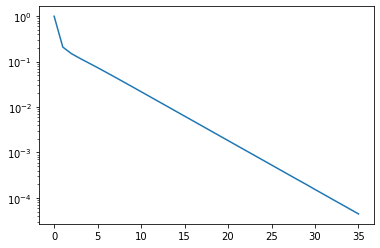

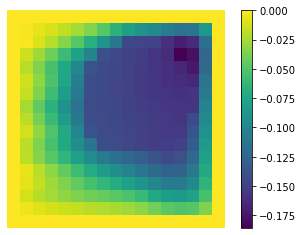

In [ ]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [ ]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 3.0214178562164307
0.17198183748515092 2.9288148880004883
0.22269928639042127 6.099668025970459
0.1377310752825802 6.626187324523926
0.36470102700064544 15.318992614746094
0.5431354025337152 20.54654884338379
0.7686057304602284 47.17344665527344
1.2730624156544856 79.00047302246094
1.2461405575024425 170.8119354248047
1.4827602675524654 321.2808837890625
1.4333301853348417 669.509765625
1.4904356724505972 1320.064453125
1.474721646773588 2707.5166015625
1.4887693463374658 5435.49853515625
1.4848518736068437 11079.31640625
1.4890265153494422 22396.26171875
1.4883463676278659 45541.5
1.4898977825209645 92304.90625
1.489999489941914 187520.859375
1.490710687041425 380464.71875
1.4909394040781179 772637.125
1.4913204697610212 1568239.125
1.4915190237095208 3184234.5
1.4917435263391052 6464079.0
1.491888829477803 13124094.0
1.492027573799144 26643686.0
1.4921273429503414 54093196.0
1.4922156787599372 109818392.0
1.4922821060412197 222954592.0
1.4923389979635489 452637632.0
1.49238291199

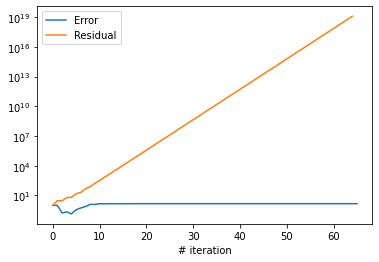

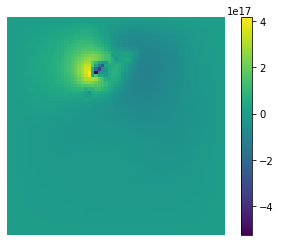

In [ ]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [ ]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.8388893226860222
